In [1]:
from tpot import TPOTRegressor
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection   import GridSearchCV
import plotly.express as px

## DATA

In [2]:
%%time
# data
acidoCEST_ML = pd.read_csv('acido_CEST_MRI_MegaBox_01_to_08_clean.csv')
acidoCEST_ML = acidoCEST_ML.drop(['Unnamed: 0','ApproT1(sec)','FILE'], axis = 1)
c = acidoCEST_ML.iloc[:,10::].columns.tolist()

Z = acidoCEST_ML.iloc[:,10::].copy()

freqs = np.array( [float(x) for x in Z.columns ] )
freqs = freqs - freqs[np.argmin(Z.median().values )]
Z.columns = [str( np.round(x,2)) for x in freqs ]

f1 = acidoCEST_ML['SatTime(ms)'] > 2000
f2 = acidoCEST_ML['SatPower(uT)'] > 1.
f3 = acidoCEST_ML['Conc(mM)'] > 10
f4 = acidoCEST_ML.Temp = 37

CPU times: user 454 ms, sys: 55.6 ms, total: 510 ms
Wall time: 508 ms


## LASSO (Linear Model)

$$ \min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1} $$

In [3]:
X = Z.copy()
y = acidoCEST_ML.pH

In [32]:
alphas = np.linspace(1E-6,1E-3,200)

selected_freqs = []

l = ['alpha']
l.extend(Z.columns)

I = pd.DataFrame( np.zeros( (len(alphas), len(l) ) ), columns= l )


for i,A in enumerate(alphas):
    L = Lasso(alpha = A, fit_intercept=True , normalize=False,max_iter=1000000,tol=.01).fit(X,y)
    model = SelectFromModel(L, prefit=True)
    X_new = model.transform(X)
    selected_freqs.append( X_new.shape[1] )
    
    I.loc[i,'alpha'] = A
    
    I.loc[i, Z.columns] = L.coef_
    


In [33]:
w= (I.loc[:, Z.columns] !=0)*1
w = 100 * w.sum()/ 1000
w = pd.DataFrame(w.reset_index())
w.columns = ['Saturation Frequency','Selection']

fig = px.scatter(w, x="Saturation Frequency", y='Selection', title='Time (%) a frequency is non zero for 1000 alphas')
fig.show()

In [34]:
w = np.abs(I.loc[:, Z.columns]).mean()
w = pd.DataFrame(w.reset_index())
w.columns = ['Saturation Frequency','Mean Coefficient']
fig = px.scatter(w, x="Saturation Frequency", y='Mean Coefficient'
              , title='Mean Importance for 1000 alphas')
fig.show()

In [35]:
w = w.sort_values('Mean Coefficient',ascending=False)
w['LASSO_rank'] = np.arange(1,82)


### Performance

In [36]:
parameters = {'alpha': alphas}

X = Z[f1 & f2 & f3 & f4]
y = acidoCEST_ML.pH[f1 & f2 & f3 & f4]

L = Lasso(fit_intercept=True , normalize=False,max_iter=1000000,tol=.01, positive=False)
clf = GridSearchCV(L, parameters ,verbose=1, n_jobs=-1, cv=3, scoring='r2')
clf.fit(X,y )

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   26.1s
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   32.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   35.8s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.01, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 6.02010050e-06, 1.10402010e-05, 1.60603015e-05,
       2.10804020e-05, 2...
       9.04618090e-04, 9.09638191e-04, 9.14658291e-04, 9.19678392e-04,
       9.24698492e-04, 9.29718593e-04, 9.34738693e-04, 9.39758794e-04,
       9.44778894e-04, 9.49798995e-04, 9.54819095e-04, 9.59839196e-04,
       9.64859296e-04, 9.69879397e-04, 9.74899497e-04, 9.79919598e-04,
       9.84939698e-04, 9.89959799e-04, 9.94979899e-04, 1.00000000e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=1)

In [37]:
clf.best_estimator_

Lasso(alpha=3.112060301507538e-05, copy_X=True, fit_intercept=True,
      max_iter=1000000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.01, warm_start=False)

Text(0, 0.5, 'R2')

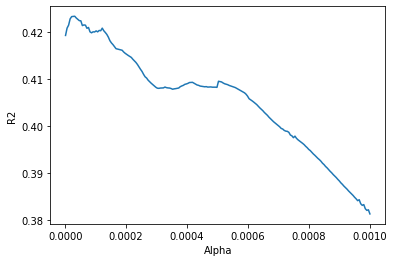

In [38]:
plt.plot(alphas, clf.cv_results_['mean_test_score'])
plt.xlabel('Alpha')
plt.ylabel('R2')

## Random Forest Regressor

In [39]:
%%time

parameters = {'n_estimators': [1,2,10,50,100]}

RfR = RandomForestRegressor()
clf2 = GridSearchCV(RfR, parameters ,verbose=1, n_jobs=-1, cv=3, scoring='r2')
clf2.fit(X,y )

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   18.5s finished


CPU times: user 23.5 s, sys: 67 ms, total: 23.6 s
Wall time: 42 s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [40]:
clf2.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [41]:
clf2.cv_results_['mean_test_score']

array([0.20321854, 0.46875687, 0.63977461, 0.67379929, 0.67624501])

In [42]:
best = clf2.best_estimator_
FI = pd.DataFrame(best.feature_importances_,index=X.columns)
FI = FI.reset_index()
FI.columns =['Saturation Frequency', 'Importance']
fig = px.scatter(FI, x="Saturation Frequency", y='Importance', title='Time (%) a frequency is non zero for 1000 alphas')
fig.show()

In [43]:
FI = FI.sort_values('Importance',ascending=False)
FI['RF_rank'] = np.arange(1,82)

In [44]:
C = FI.merge(w, left_on='Saturation Frequency',right_on='Saturation Frequency')

In [45]:
C

,Saturation Frequency,Importance,RF_rank,Mean Coefficient,LASSO_rank
0,5.7,0.102502,1,1.839462,1
1,4.5,0.084305,2,0.468379,9
2,4.3,0.072264,3,1.123805,3
3,4.4,0.071196,4,0.715501,8
4,5.8,0.052632,5,0.725876,6
...,...,...,...,...,...
76,7.4,0.002302,77,0.027252,43
77,-6.2,0.002262,78,0.367996,12
78,7.2,0.002241,79,0.005098,62
79,11.8,0.002222,80,0.003364,64


In [47]:
C.sort_values('RF_rank',ascending=True).head(10)

,Saturation Frequency,Importance,RF_rank,Mean Coefficient,LASSO_rank
0,5.7,0.102502,1,1.839462,1
1,4.5,0.084305,2,0.468379,9
2,4.3,0.072264,3,1.123805,3
3,4.4,0.071196,4,0.715501,8
4,5.8,0.052632,5,0.725876,6
5,5.6,0.047703,6,1.690669,2
6,4.2,0.044374,7,0.297829,15
7,0.0,0.032002,8,0.172292,20
8,0.2,0.031685,9,0.058817,28
9,4.6,0.029767,10,0.907771,4


In [53]:
selected_freqs = C[(C.RF_rank <=20) | (C.LASSO_rank <=20)]['Saturation Frequency']
col_list_sel_freqs = [str(f) for f in selected_freqs ]
col_list_sel_freqs.sort()
print( len(col_list_sel_freqs ))
col_list_sel_freqs

27


['-1.2',
 '-1.4',
 '-1.6',
 '-3.2',
 '-6.2',
 '0.0',
 '0.2',
 '0.4',
 '1.8',
 '2.0',
 '3.3',
 '3.9',
 '4.0',
 '4.1',
 '4.2',
 '4.3',
 '4.4',
 '4.5',
 '4.6',
 '4.7',
 '4.8',
 '4.9',
 '5.5',
 '5.6',
 '5.7',
 '5.8',
 '5.9']

In [70]:
w = Z[col_list_sel_freqs].melt()
w.columns = ['Sat Freq','CEST Signal']

<AxesSubplot:xlabel='Sat Freq', ylabel='CEST Signal'>

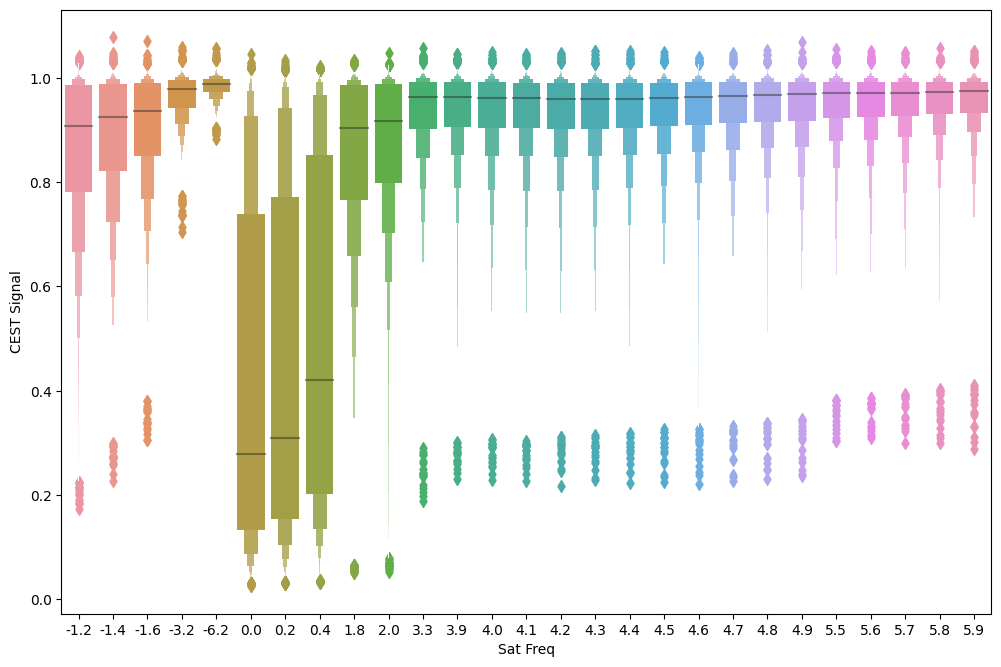

In [78]:
plt.figure(dpi=100, figsize=(12,8))

sns.boxenplot(x='Sat Freq',y='CEST Signal',data=w)

## autoML with selected frequencies

In [79]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.2" 2020-01-14; Java(TM) SE Runtime Environment (build 13.0.2+8); Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/jcarde20/Library/Python/3.8/lib/python/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/d_/pj93f9nd3k9fq5d2jcwxdbq9n_t54d/T/tmpogl2rpf3
  JVM stdout: /var/folders/d_/pj93f9nd3k9fq5d2jcwxdbq9n_t54d/T/tmpogl2rpf3/h2o_jcarde20_started_from_python.out
  JVM stderr: /var/folders/d_/pj93f9nd3k9fq5d2jcwxdbq9n_t54d/T/tmpogl2rpf3/h2o_jcarde20_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Phoenix
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,4 months and 21 days !!!
H2O_cluster_name:,H2O_from_python_jcarde20_0hmd7p
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


In [80]:
data = h2o.H2OFrame(pd.concat( (acidoCEST_ML.pH, Z),axis=1))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [81]:
train, test, val = data.split_frame( ratios = [.7, .25] )

,pH,Conc(mM),ExpT1(ms),ExpT2(ms),ExpB1(percent),ExpB0(ppm),ExpB0(Hz),Temp,SatPower(uT),SatTime(ms),...,7,7.2,7.4,7.6,7.8,8,9,10,11,12
0,6.24,9.9870,402.70,201.72,118.130,0.58603,176.000,37,3.0,2000,...,0.971111,0.980716,0.979566,0.979752,0.984350,0.984906,0.984795,0.984350,0.984981,0.988652
1,6.38,9.9761,388.31,214.49,107.810,0.70919,212.990,37,3.0,2000,...,0.980465,0.974735,0.983810,0.980580,0.989117,0.976427,0.985118,0.992963,0.982541,0.986118
2,6.58,9.9800,393.20,217.77,103.080,0.76500,229.760,37,3.0,2000,...,0.990908,0.993978,0.986067,0.977566,0.994293,0.991026,0.993073,0.995671,0.995749,0.994293
3,6.69,9.9582,389.14,217.87,106.210,0.63908,191.940,37,3.0,2000,...,0.977619,0.978972,0.969579,0.976034,0.980634,0.977116,0.982064,0.984422,0.980634,0.978856
4,6.84,9.9502,379.38,214.10,111.260,0.33744,101.340,37,3.0,2000,...,0.979530,0.976333,0.986626,0.980583,0.986158,0.983624,0.992982,0.984248,0.985690,0.985417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35995,6.38,9.9631,4112.50,601.83,101.610,0.22259,66.852,37,4.0,2000,...,0.957295,0.957801,0.955397,0.963685,0.965772,0.971340,0.970454,0.969379,0.977224,0.973871
35996,6.58,9.9631,3918.70,575.72,109.390,0.33517,100.660,37,4.0,2000,...,0.940677,0.947761,0.947329,0.948518,0.962200,0.957766,0.959604,0.972637,0.972475,0.975827
35997,6.70,9.9473,3911.10,593.31,106.630,0.40331,121.130,37,4.0,2000,...,0.938586,0.947827,0.960817,0.957015,0.945187,0.958494,0.969953,0.978560,0.972963,0.975022
35998,6.88,9.9206,4043.40,632.75,99.980,0.35798,107.510,37,4.0,2000,...,0.949383,0.938830,0.944454,0.961153,0.959413,0.963356,0.961674,0.969676,0.977967,0.983243


## -all

In [82]:
x = data.columns
y = "pH"
x.remove(y)


# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1, verbosity='info',nfolds=3,max_runtime_secs=3600)

aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
11:14:16.786: Project: AutoML_20210219_111416784
11:14:16.787: Setting stopping tolerance adaptively based on the training frame: 0.006296909605425953
11:14:16.787: Build control seed: 1
11:14:16.787: training frame: Frame key: automl_training_py_2_sid_999e    cols: 82    rows: 25220  chunks: 14    size: 16446068  checksum: 2673810440025744213
11:14:16.787: validation frame: NULL
11:14:16.788: leaderboard frame: NULL
11:14:16.788: blending frame: NULL
11:14:16.788: response column: pH
11:14:16.788: fold column: null
11:14:16.788: weights column: null
11:14:16.805: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
11:14:16.815: AutoML job created: 2021.02.19 11:14:16.784
11:14:16.816: AutoML build started: 2021.02.19 11:14:16.816
11:14:16.824

In [83]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20210219_111416_model_2,0.0568417,0.238415,0.0568417,0.183493,0.0308136
GBM_4_AutoML_20210219_111416,0.0568667,0.238467,0.0568667,0.182796,0.0308189
GBM_3_AutoML_20210219_111416,0.0573292,0.239435,0.0573292,0.185294,0.0309432
DRF_1_AutoML_20210219_111416,0.0579884,0.240808,0.0579884,0.18913,0.0311325
XRT_1_AutoML_20210219_111416,0.0581207,0.241082,0.0581207,0.189384,0.0311659
GBM_5_AutoML_20210219_111416,0.058225,0.241299,0.058225,0.187896,0.0311813
GBM_2_AutoML_20210219_111416,0.0582475,0.241345,0.0582475,0.188237,0.0311898
DeepLearning_1_AutoML_20210219_111416,0.058251,0.241352,0.058251,0.186842,0.0312066
GBM_1_AutoML_20210219_111416,0.0596039,0.244139,0.0596039,0.191021,0.0315387
GBM_grid__1_AutoML_20210219_111416_model_1,0.0617817,0.248559,0.0617817,0.195804,0.0321118


## autoML with selected freqs 

In [84]:
col_list_sel_freqs

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml2 = H2OAutoML(max_models=20, seed=1, verbosity='info',nfolds=3,max_runtime_secs=3600)

aml2.train(x = col_list_sel_freqs, y=y, training_frame=train)


AutoML progress: |
11:26:30.836: Project: AutoML_20210219_112630836
11:26:30.836: Setting stopping tolerance adaptively based on the training frame: 0.006296909605425953
11:26:30.836: Build control seed: 1
11:26:30.836: training frame: Frame key: automl_training_py_2_sid_999e    cols: 82    rows: 25220  chunks: 14    size: 16446068  checksum: 2673810440025744213
11:26:30.836: validation frame: NULL
11:26:30.836: leaderboard frame: NULL
11:26:30.836: blending frame: NULL
11:26:30.836: response column: pH
11:26:30.836: fold column: null
11:26:30.837: weights column: null
11:26:30.837: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
11:26:30.837: AutoML job created: 2021.02.19 11:26:30.836
11:26:30.837: AutoML build started: 2021.02.19 11:26:30.837
11:26:30.838

In [85]:
# View the AutoML Leaderboard
lb = aml2.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20210219_112630_model_2,0.059396,0.243713,0.059396,0.188304,0.0314943
DRF_1_AutoML_20210219_112630,0.0597257,0.244388,0.0597257,0.192405,0.0315877
XRT_1_AutoML_20210219_112630,0.0600502,0.245051,0.0600502,0.192771,0.0316734
GBM_4_AutoML_20210219_112630,0.0606314,0.246234,0.0606314,0.190948,0.0318165
GBM_2_AutoML_20210219_112630,0.06071,0.246394,0.06071,0.192297,0.0318313
GBM_5_AutoML_20210219_112630,0.0610655,0.247114,0.0610655,0.193423,0.0319298
GBM_3_AutoML_20210219_112630,0.0613221,0.247633,0.0613221,0.193428,0.0319928
GBM_1_AutoML_20210219_112630,0.0622096,0.249419,0.0622096,0.196354,0.0322188
DeepLearning_1_AutoML_20210219_112630,0.0622643,0.249528,0.0622643,0.194979,0.03222
GBM_grid__1_AutoML_20210219_112630_model_1,0.0643382,0.25365,0.0643382,0.200785,0.032762


## selected freqs and exp data

In [91]:

data = h2o.H2OFrame(pd.concat( (acidoCEST_ML[['ExpT1(ms)', 'ExpT2(ms)','ExpB0(ppm)','SatPower(uT)', 'SatTime(ms)','pH']]
                                , Z),axis=1))

x = data.columns
y = "pH"
x.remove(y)


# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, seed=1, verbosity='info',nfolds=3,max_runtime_secs=3600)

train, test, val = data.split_frame( ratios = [.7, .25] )

aml.train(x=x, y=y, training_frame=train)

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
11:49:07.551: Project: AutoML_20210219_114907551
11:49:07.551: Setting stopping tolerance adaptively based on the training frame: 0.006294538992335746
11:49:07.551: Build control seed: 1
11:49:07.551: training frame: Frame key: automl_training_py_533_sid_999e    cols: 87    rows: 25239  chunks: 14    size: 16722969  checksum: -4628074696379396896
11:49:07.551: validation frame: NULL
11:49:07.551: leaderboard frame: NULL
11:49:07.551: blending frame: NULL
11:49:07.551: response column: pH
11:49:07.551: fold column: null
11:49:07.551: weights column: null
11:49:07.552: Loading execution steps: [{XGBoost : defaults}, {GLM : defaults}, {DRF : [def_1]}, {GBM : defaults}, {DeepLearning : defaults}, {DRF : [XRT]}, {XGBoost : grids}, {GBM : grids}, {DeepLearning : grids}, {GBM : [lr_annealing]}, {XGBoost : [lr_search]}, {StackedEnsemble : defaults}]
11:49:07.552: AutoML job created: 2021.02.19 1

In [92]:
# View the AutoML Leaderboard
lb = aml2.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_grid__1_AutoML_20210219_112630_model_2,0.059396,0.243713,0.059396,0.188304,0.0314943
DRF_1_AutoML_20210219_112630,0.0597257,0.244388,0.0597257,0.192405,0.0315877
XRT_1_AutoML_20210219_112630,0.0600502,0.245051,0.0600502,0.192771,0.0316734
GBM_4_AutoML_20210219_112630,0.0606314,0.246234,0.0606314,0.190948,0.0318165
GBM_2_AutoML_20210219_112630,0.06071,0.246394,0.06071,0.192297,0.0318313
GBM_5_AutoML_20210219_112630,0.0610655,0.247114,0.0610655,0.193423,0.0319298
GBM_3_AutoML_20210219_112630,0.0613221,0.247633,0.0613221,0.193428,0.0319928
GBM_1_AutoML_20210219_112630,0.0622096,0.249419,0.0622096,0.196354,0.0322188
DeepLearning_1_AutoML_20210219_112630,0.0622643,0.249528,0.0622643,0.194979,0.03222
GBM_grid__1_AutoML_20210219_112630_model_1,0.0643382,0.25365,0.0643382,0.200785,0.032762
